In [1]:
import matplotlib.pyplot as plt
import re
from sklearn.metrics import silhouette_score
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.cluster import KMeans

import pandas as pd
import gensim
import numpy as np
from gensim.models import Word2Vec
from time import time  # To time our operations
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import random 

data = pd.read_csv("obamaprocessed.csv")
data.drop("Unnamed: 0",inplace=True,axis=1)
data

,text,year,week_year,modded_text,modded1,noTags_punct,modded1_stemmed
0,RT @CDC_eHealth: New CDC widget - Tips for pre...,2009,18,rt @cdc_ehealth: new cdc widget - tips for pre...,rt cdc_ehealth new cdc widget tips preventing ...,rt cdc_ehealth new cdc widget tips for preven...,rt cdc_ehealth new cdc widget tip preve...
1,RT @DHSJournal: Press Briefing VIDEO: Homeland...,2009,18,rt @dhsjournal: press briefing video: homeland...,rt dhsjournal press briefing video homeland se...,rt dhsjournal press briefing video homeland se...,rt dhsjournal press brief video homeland...
2,RT @CDC_eHealth Add a graphic with flu prevent...,2009,18,rt @cdc_ehealth add a graphic with flu prevent...,rt add graphic flu prevention messages webpage...,rt add a graphic with flu prevention message...,rt add graphic flu prevent messag webpa...
3,The President's Remarks on Justice Souter: The...,2009,18,the president's remarks on justice souter: the...,presidents remarks justice souter president ma...,the presidents remarks on justice souter the p...,presid remark justic souter presid made ...
4,WhiteHouse 2.0: Today the White House is takin...,2009,18,whitehouse 2.0: today the white house is takin...,whitehouse 20 today white house taking steps e...,whitehouse 20 today the white house is taking ...,whitehous 20 today white hous take step...
5,Shooting Around With the Huskies: The Presiden...,2009,18,shooting around with the huskies: the presiden...,shooting around huskies president shot hoops u...,shooting around with the huskies the president...,shoot around huski presid shot hoop und...
6,RT @CDC_eHealth Check out CDC's new webpage hi...,2009,18,rt @cdc_ehealth check out cdc's new webpage hi...,rt check cdcs new webpage highlighting several...,rt check out cdcs new webpage highlighting s...,rt check cdc new webpag highlight sever...
7,Check out the CDC website (www.cdc.gov) or @CD...,2009,18,check out the cdc website (www.cdc.gov) or @cd...,check cdc website wwwcdcgov learn h1n1 flu swi...,check out the cdc website wwwcdcgov or to le...,check cdc websit wwwcdcgov learn h1n1 f...
8,Welcome to the official Twitter page for the W...,2009,18,welcome to the official twitter page for the w...,welcome official twitter page white house,welcome to the official twitter page for the w...,welcom offici twitter page white hous
9,“My Fellow Americans”: The President attends a...,2009,18,“my fellow americans”: the president attends a...,fellow americans president attends naturalizat...,my fellow americans the president attends a ...,fellow american presid attend natur cere...


11123


<function matplotlib.pyplot.show(*args, **kw)>

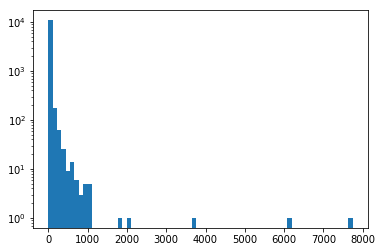

In [2]:
stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
print(len(stemmed_words))
plt.hist(stemmed_words.values,bins=70,log=True)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

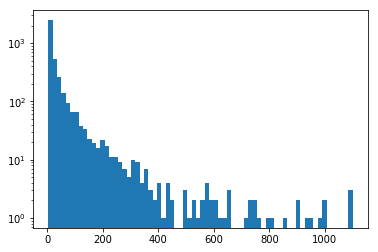

In [4]:
stemmed_words = stemmed_words[stemmed_words > 3]
stemmed_words = stemmed_words[stemmed_words < 1500]
plt.hist(stemmed_words.values,bins=70,log=True)
plt.show

In [ ]:
#data['m'] = data['modded1'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))
#pd.Series(' '.join(data['m']).split()).value_counts()
#sentences = data[data["year"] == 2016]["m"].tolist()


In [5]:
#don't count words
#sentences = data[data["year"] == 2016]["noTags_punct"].tolist()

#pre-campaign
data1 = data[data["year"] <= 2016]
data1 = data1[data1["year"] >= 2015]

#post campaign
#data1 = data[data["year"] >= 2017]
#sentences = data1["noTags_punct"].tolist()

#print(len(data1),len(sentences))
data1["year"].unique()
sentences = data1["noTags_punct"].tolist()

In [6]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[i]) for i, _d in enumerate(sentences)]
tagged_data

[TaggedDocument(words=['happy', 'new', 'year'], tags=[0]),
 TaggedDocument(words=['more', 'than', '26', 'million', 'new', 'jobs', '10', 'million', 'americans', 'gained', 'coverage', 'check', 'out', 'the', 'progress', 'we', 'made', 'in', '2014'], tags=[1]),
 TaggedDocument(words=['check', 'out', 'the', 'top', '10', 'white', 'house', 'series', 'from', '2014', 'as', 'determined', 'by', 'our', 'tumblr', 'followers'], tags=[2]),
 TaggedDocument(words=['watch', 'this', 'if', 'you', 'love', 'behindthescenes', 'moments', 'with', 'president', 'obama', 'and', 'the', 'vp', 'westwingweek'], tags=[3]),
 TaggedDocument(words=['student', 'filmmakers', 'submit', 'your', '3min', 'video', 'on', 'the', 'impact', 'of', 'giving', 'back', 'for', 'the', 'whfilmfest'], tags=[4]),
 TaggedDocument(words=['2014', 'in', 'review', 'president', 'obama', 'became', 'the', '1st', 'president', 'to', 'write', 'a', 'line', 'of', 'code'], tags=[5]),
 TaggedDocument(words=['presssec', 'on', 'president', 'obama', 'imposing'

In [7]:
len(tagged_data)

6555

In [8]:
#model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
#model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
#model = Doc2Vec(vector_size=200, min_count=2, epochs=40)
model = Doc2Vec(vector_size=500, min_count=4, epochs=100)

model.build_vocab(tagged_data)


In [9]:
%%time 
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


CPU times: user 1min 21s, sys: 6.61 s, total: 1min 28s
Wall time: 40.5 s


In [10]:
%%time
#sentences = data[data["year"] == 2016]["noTags_punct"].tolist()
#tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[i]) for i, _d in enumerate(sentences)]

X = []
for i in range(0,len(tagged_data)):
    X.append( model.infer_vector(tagged_data[i].words))

CPU times: user 43.6 s, sys: 53.2 ms, total: 43.6 s
Wall time: 43.7 s


In [11]:
%%time
ranks = []
second_ranks = []
for doc_id in range(len(tagged_data)):
    inferred_vector = model.infer_vector(tagged_data[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

CPU times: user 30min 33s, sys: 1h 15min 20s, total: 1h 45min 53s
Wall time: 4min 55s


In [12]:
import collections

collections.Counter(ranks)  # Results vary between runs due to random seeding and very small corpus


Counter({1: 103,
         0: 6428,
         9: 2,
         4: 4,
         2: 10,
         18: 1,
         2121: 1,
         3902: 1,
         3: 2,
         3863: 1,
         5420: 1,
         6174: 1})

In [13]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_data[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]: 
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(tagged_data[sims[index][0]].words)))


Document (6554): «nothing can break the spirit of the greek people you will overcome this period of challenge potus in athens»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d500,n5,w5,mc4,s0.001,t3):

MOST (6554, 0.9062680602073669): «nothing can break the spirit of the greek people you will overcome this period of challenge potus in athens»

SECOND-MOST (2354, 0.476224422454834): «a couple years ago i stood with you as you showed the world that no tragedy can compete with boston strong potus in boston laborday»

MEDIAN (1668, 0.18039235472679138): «potus and the vp watch as the senate takes the next step toward passing the most progressive trade deal ever»

LEAST (3681, -0.17412477731704712): «we have to make college affordable for every american potus sotu»



In [15]:
doc_id = random.randint(0, len(tagged_data) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_data[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(tagged_data[sim_id[0]].words)))


Train Document (4504): «we ve made significant progress potus alongside more than 50 world leaders at the»

Similar Document (4591, 0.5593761801719666): «happening now watch potus speak at the newlydesignated belmontpaul womens equality national monument»



# hierachical


from sklearn.cluster import AgglomerativeClustering

#average 
#2 0.20235462
#3 0.17323813
#4 0.15857914
#5 0.15378755
#6 0.078243
#7 0.051599164
#8 0.036651324
#9 0.028211854


for c in range(2,10):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(X)
    labels = clustering.labels_
    d = silhouette_score(X, labels,metric='cosine')
    print(c,d)

clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=6)
clustering.fit(X)
assigned_clusters = clustering.labels_
d = silhouette_score(X, assigned_clusters,metric='cosine')

print(d)
NUM_CLUSTERS = 5

# kmeans

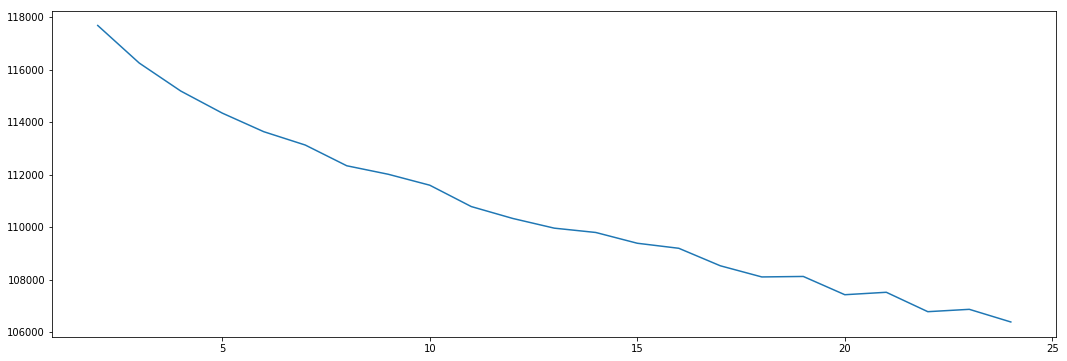

CPU times: user 8min 59s, sys: 10min 6s, total: 19min 5s
Wall time: 3min 26s


In [16]:
%%time

#solo per aveere un'idea di quanti cluster
sse_list = list()
max_k = 25
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [17]:
%%time
#stemmed counted
#0.112 8 cluster 
#0.12 8 cluster con lunghezza vettore 100
#0.135 8 cluster con lunghezza vettore 200
#0.133 8 cluster con lunghezza vettore 300

#not stemmed counted
#0.135 8 cluster con lunghezza 100
#0.149 8 cluster con lunghezza 200
#0.148 8 cluster con lunghezza 300

#all words not stemmed, no stopwords
#0.114 6 cluster 100
#0.136 8 cluster 100
#0.122 8 cluster 200
#0.144 8 cluster 300


#5 cluster not stemmed, 300, full sembra faccia cluster nicely, 0.14 e passa 
#4 " ", 0.142

#doc2vec trained on whole dataset, lower silhouettes, words?
#4 0.66
#6 0.64

#4 0.79 500/min 4

#30 cluster su 2015/2016 silhouette 0.02 e passa
#10   0.028/0.28 non ho visto 
#15 0.027
#8 0.026
#5 0.026


NUM_CLUSTERS = 8
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=40)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print (assigned_clusters)
d = silhouette_score(X, assigned_clusters,metric='cosine')
print(d)

0.030669594
CPU times: user 23min 50s, sys: 2.16 s, total: 23min 52s
Wall time: 23min 49s


In [18]:
datak = data1
datak["labels"] = assigned_clusters

In [19]:
clusters_wordCount = []
for cluster in range(0,NUM_CLUSTERS):
    c = datak[datak["labels"] == cluster]
    print(len(c))
   # words = pd.Series(' '.join(c['m']).split()).value_counts()
    words = pd.Series(' '.join(c['modded1']).split()).value_counts()
    m = words.mean()
    words = words[words > m]
    clusters_wordCount.append(words)
    print("Cluster " + str(cluster) + " dimension " + str(len(c)))

689
Cluster 0 dimension 689
462
Cluster 1 dimension 462
798
Cluster 2 dimension 798
1081
Cluster 3 dimension 1081
757
Cluster 4 dimension 757
1550
Cluster 5 dimension 1550
561
Cluster 6 dimension 561
657
Cluster 7 dimension 657


In [20]:
for c in range(0,NUM_CLUSTERS):
    print("cluster ", c , clusters_wordCount[c][0:10])

cluster  0 obama        624
president    515
watch         71
america       58
new           45
american      43
one           38
make          37
potus         37
people        36
dtype: int64
cluster  1 potus        325
obama         61
america       56
us            44
president     33
make          30
time          28
years         27
world         26
sotu          25
dtype: int64
cluster  2 potus        521
people        75
obama         65
us            63
watch         63
president     55
americans     48
america       45
every         43
world         39
dtype: int64
cluster  3 potus        928
people        76
watch         66
americans     59
us            55
america       54
one           52
every         50
american      49
years         43
dtype: int64
cluster  4 potus        554
watch        129
sotu         103
obama         67
president     52
et            47
american      46
us            43
people        41
americans     38
dtype: int64
cluster  5 potus           414

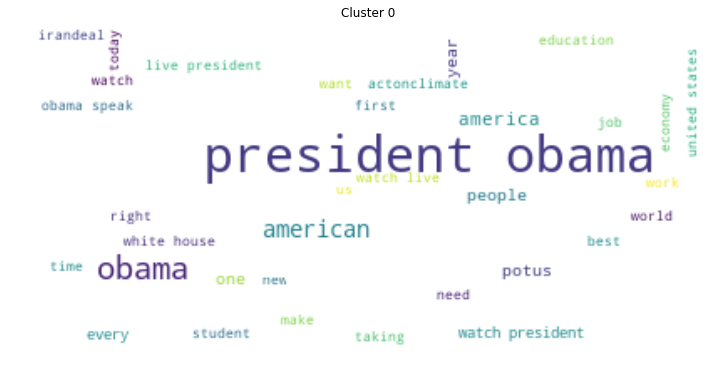

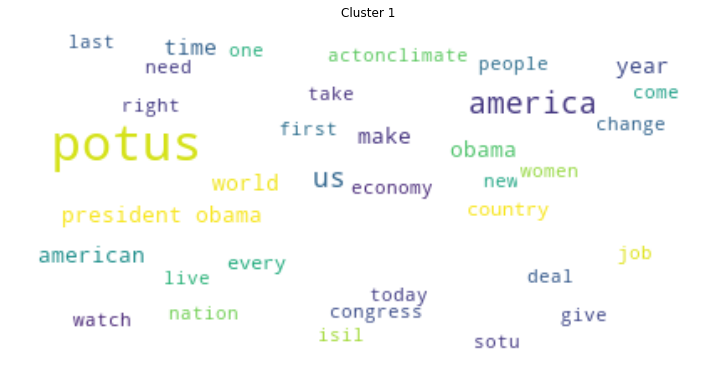

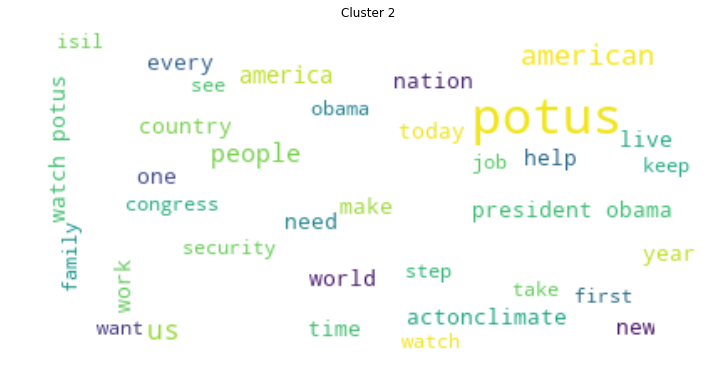

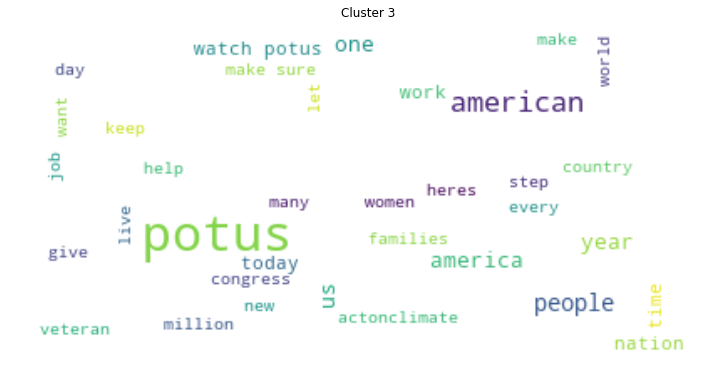

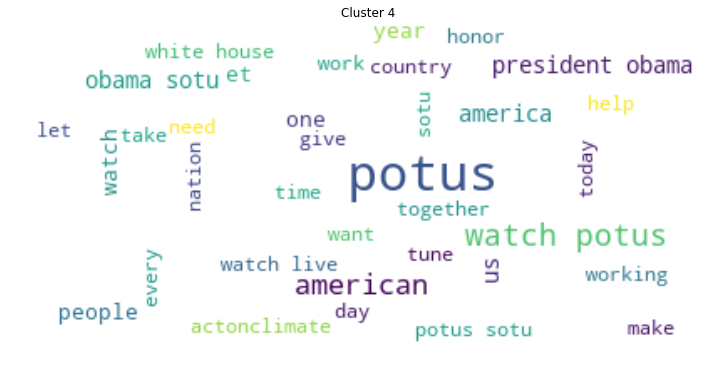

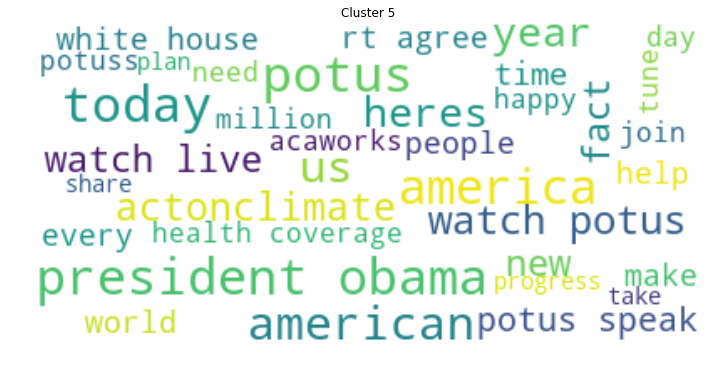

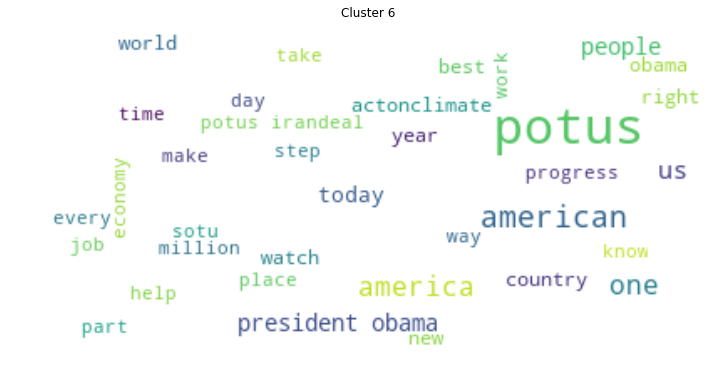

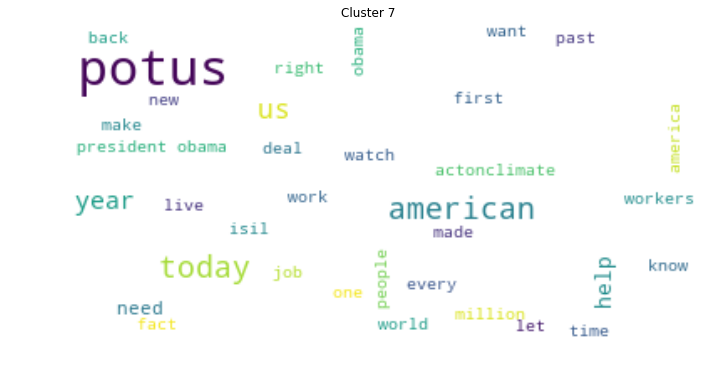

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

for c in range(0,NUM_CLUSTERS):
    temp = datak[datak["labels"] == c] 
    print
    text = temp["modded1"]
    text = text.str.cat(sep=' ')

    wordcloud = WordCloud(max_font_size=30, max_words=35, background_color="white").generate(text)
    plt.figure(figsize=(12,10))    
    plt.title("Cluster " + str(c))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [ ]:
#trova un modo di clusterizzare le cose assieme ai dati / sentiment analysis

In [22]:
datak.to_csv("Obama1516Clustered.csv")